In [1]:
import numpy as np
import utility_module_2_v_3 as uu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset
import numpy.ma as ma


In [2]:
# Globals
B=100

In [3]:
path_obs='/media/vikram/subimal/Raw_Data/CRU/'
path_gcm = '/media/vikram/subimal/Raw_Data/GCM_BCSD_DATA/'
path_out = '/home/vikram/BCSD_data/' + 'US_P_BCSD/'

In [4]:

st=1901
en=2005
data_bounds_cru=[ -125, 50, -70, 25]
data_bounds=[ 360-125, 50, 360-70, 25]

map_bounds= data_bounds
mp_spacing=10


# Read CRU data

In [5]:
filename =path_obs +'cru_ts3.23.1901.2014.pre.dat.nc'
fh = Dataset(filename, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
#print(fh)
data = fh.variables['pre'][:]

dt_st=0
dt_en=(en-st+1)*12


# cropping the study area out
l_lat,u_lat,lat_obs_cru=uu.find_bounds(lats,data_bounds_cru[3],data_bounds_cru[1])
l_lon,u_lon,lon_obs_cru=uu.find_bounds(lons,data_bounds_cru[0],data_bounds_cru[2])
lon_obs_cru=360+lon_obs_cru


pre_obs_cru=data[dt_st:dt_en,l_lat:u_lat+1,l_lon:u_lon+1]
del data
print(pre_obs_cru.shape,lat_obs_cru.shape,lon_obs_cru.shape)

(1260, 52, 112) (52,) (112,)


In [6]:
#data_obs_cru_monb=data_obs_cru_mon
pre_obs=pre_obs_cru.data
mask_fine_obs=pre_obs_cru.mask
N=pre_obs.shape[0]


In [7]:
pre_obs_cru.fill_value

9.969209968386869e+36

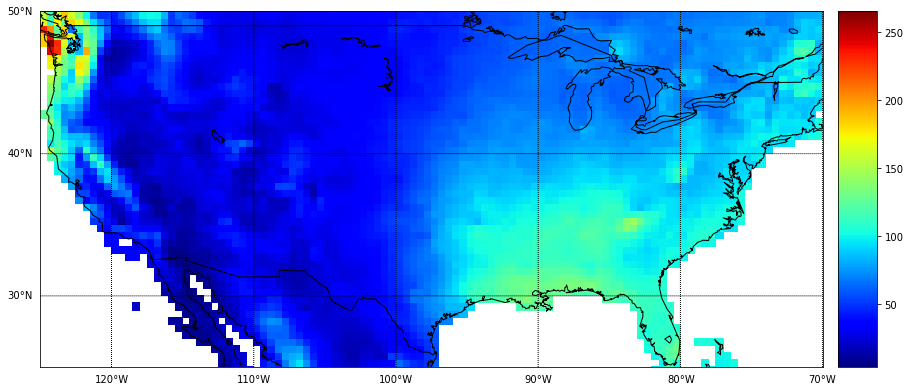

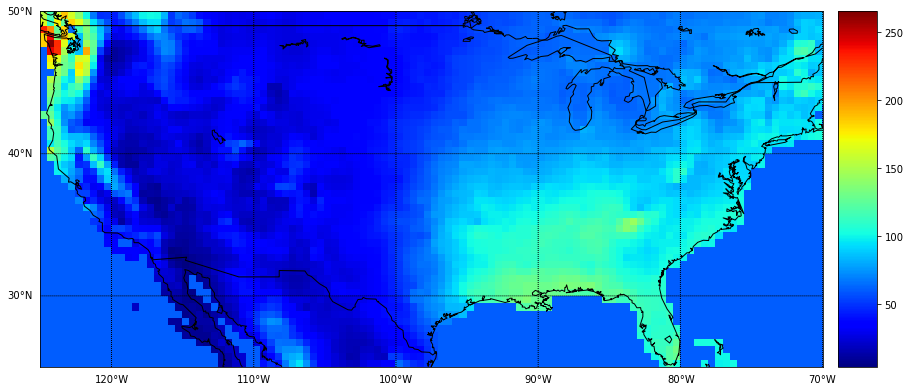

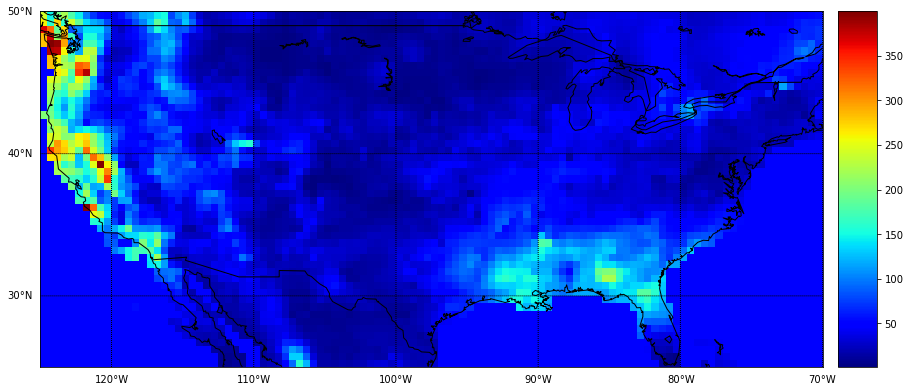

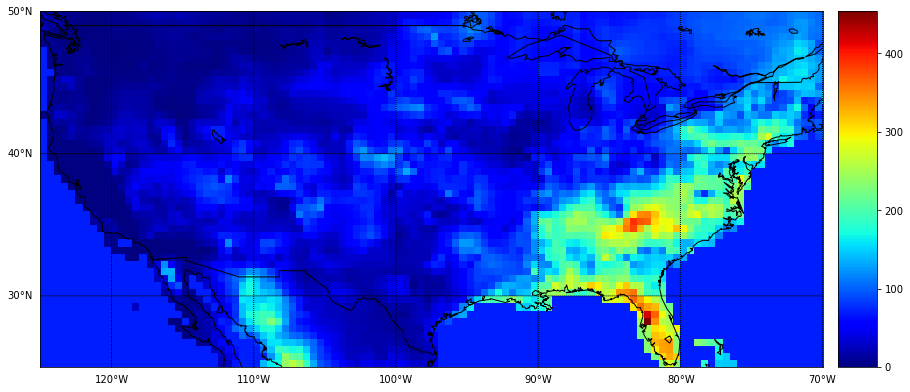

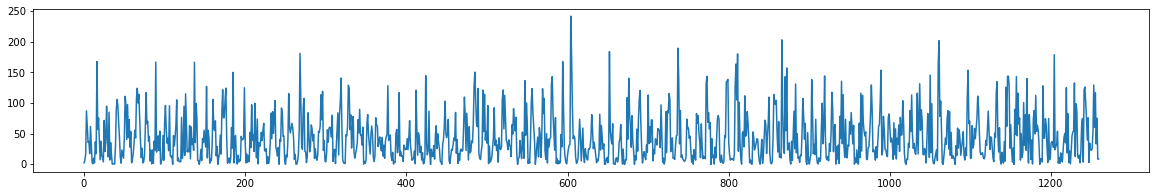

In [8]:

pre_obs[pre_obs>99999999]=np.nan
uu.map_plot_cyl(np.mean(pre_obs,axis=0),lat_obs_cru,lon_obs_cru,map_bounds,mp_spacing=10)

for t in range(N):
  pre_obs_t=pre_obs[t,:,:]
  pre_obs_t[np.isnan(pre_obs_t)]=np.nanmean(pre_obs_t)
  pre_obs[t,:,:]=pre_obs_t

uu.map_plot_cyl(np.mean(pre_obs,axis=0),lat_obs_cru,lon_obs_cru,map_bounds,mp_spacing=10)
uu.map_plot_cyl(pre_obs[1,:,:],lat_obs_cru,lon_obs_cru,map_bounds,mp_spacing=10)
uu.map_plot_cyl(pre_obs[7,:,:],lat_obs_cru,lon_obs_cru,map_bounds,mp_spacing=10)


plt.figure(figsize=(20,3))
plt.plot(pre_obs[:,25,50])

# Read GCM

In [9]:
filename =path_gcm +'/CanESM2/pr_day_CanESM2_historical_r1i1p1_18500101-20051231.nc'
fh = Dataset(filename, mode='r')
lons = fh.variables['lon'][:]
lats = fh.variables['lat'][:]
data = fh.variables['pr'][:]

# cropping the study area out
l_lat,u_lat,lat_gcm=uu.find_bounds(lats,data_bounds[3],data_bounds[1])
l_lon,u_lon,lon_gcm=uu.find_bounds(lons,data_bounds[0],data_bounds[2])

dt_data_st=np.datetime64(str(1850)+'-01-01')
dt_st=np.datetime64(str(st)+'-01-01')
dt_en=np.datetime64(str(en+1)+'-01-01')

index_of_st=((dt_st- dt_data_st) / np.timedelta64(1, 'D')).astype(int)
index_of_en=((dt_en-dt_data_st) / np.timedelta64(1, 'D')).astype(int)

pre_gcm_daily=data[index_of_st:index_of_en,l_lat:u_lat+1,l_lon:u_lon+1].data *3600*24

del data
print(pre_gcm_daily.shape,lat_gcm.shape,lon_gcm.shape)

#plotting


(38313, 11, 22) (11,) (22,)


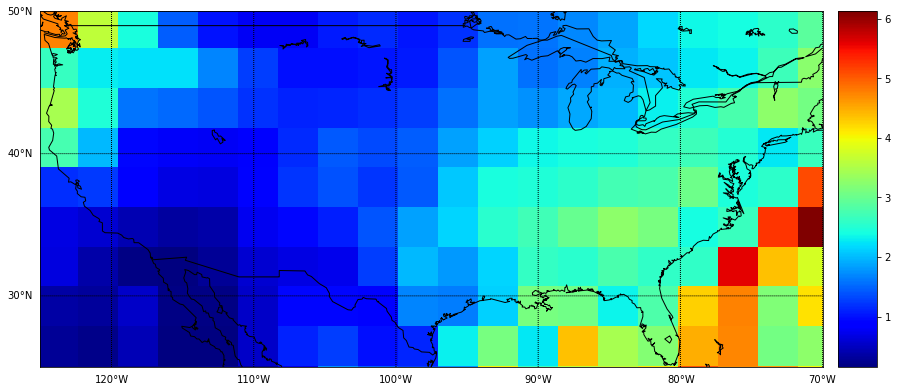

In [10]:
uu.map_plot_cyl(np.mean(pre_gcm_daily,axis=0),lat_gcm,lon_gcm,map_bounds,mp_spacing=10)


In [11]:
pre_gcm=uu.daily_to_monthly_sts(pre_gcm_daily,st,en,method='SUM')
del pre_gcm_daily

Monthly data dimensions: (1260, 11, 22)


In [12]:
pre_obs_coarse=np.zeros(pre_gcm.shape)
for i in range(pre_obs.shape[0]):
    pre_obs_coarse[i,:,:]=uu.regrid(pre_obs[i,:,:],lat_obs_cru,lon_obs_cru,lat_gcm,lon_gcm)


# Uncertainty

In [13]:
pre_gcm.shape

(1260, 11, 22)

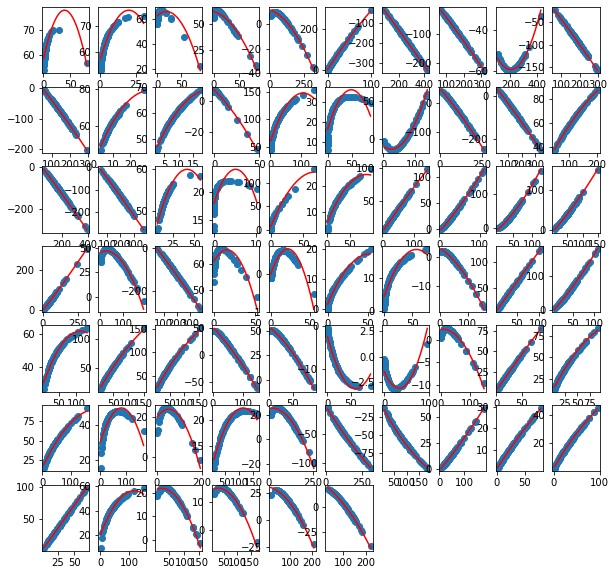

In [53]:
plt.figure(figsize = (10,10))
itetr =  0
for n1 in range(0,11,2):
    for n2 in range(0,22,2):
        itetr=itetr+1
        plt.subplot(7,10,itetr)
        data_July  =  pre_gcm[:,n1,n2].reshape((12,-1),order = 'F' )[7,:]
        data_July_obs  =  pre_obs_coarse[:,n1,n2].reshape((12,-1),order = 'F' )[7,:]
        data_July_bc = bias_corr_historical_gamma_zeros(data_July_obs,data_July)

        correction = data_July_bc - data_July


        plt.scatter(data_July,correction)
        # plt.scatter(data_July_obs,correction)
        # plt.scatter(data_July_obs,data_July)
        
        
        poly = np.polyfit(data_July, correction, deg=2)
        xx =  np.arange(np.min(data_July),np.max(data_July),0.1)
        yy = np.polyval(poly,xx)
        plt.plot(xx,yy,'r')

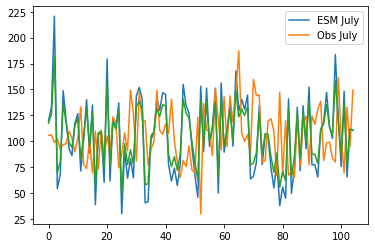

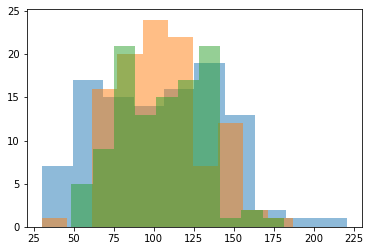

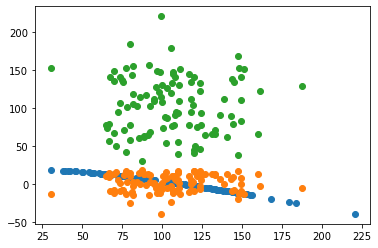

In [65]:
plt.plot(data_July)
plt.plot(data_July_obs)
plt.plot(data_July_bc)
plt.legend(['ESM July', 'Obs July'])
plt.figure()
plt.hist(data_July,alpha= 0.5 )
plt.hist(data_July_obs,alpha= 0.5 )

plt.hist(data_July_bc,alpha= 0.5 )
plt.show()

correction = data_July_bc - data_July


plt.scatter(data_July,correction)
plt.scatter(data_July_obs,correction)
plt.scatter(data_July_obs,data_July)

In [70]:
n1= 5
n2 = 10
data_July  =  pre_gcm[:,n1,n2].reshape((12,-1),order = 'F' )[7,:]
data_July_obs  =  pre_obs_coarse[:,n1,n2].reshape((12,-1),order = 'F' )[7,:]

        
x=data_July
N=x.shape[0]
samples= []
B=100

for i in range(B):
    y = np.random.choice(x.tolist(), N, replace=True)
    samples.append(y)

    
x=data_July_obs
N=x.shape[0]
samples_obs= []
for i in range(B):
    y = np.random.choice(x.tolist(), N, replace=True)
    samples_obs.append(y)



In [74]:
import scipy.stats

point_example= 25
cdfs_esm = []
cdfs_obs = []

corrs = []
for it1,samp in enumerate(samples):
    for it2,samp_obs in enumerate(samples_obs):
        a,b,c = bias_corr_historical_gamma_zeros_uncen(samp_obs,samp,point_example)
        corrs.append(a)
        if it1 == it2 :
            cdfs_esm.append(c)        
            cdfs_obs.append(b)

(array([0.00159374, 0.01173323, 0.03550194, 0.06619518, 0.06987727,
        0.04855412, 0.02585706, 0.0115134 , 0.00321496, 0.00074191]),
 array([49.44114326, 53.08038127, 56.71961928, 60.3588573 , 63.99809531,
        67.63733332, 71.27657134, 74.91580935, 78.55504737, 82.19428538,
        85.83352339]),
 <BarContainer object of 10 artists>)

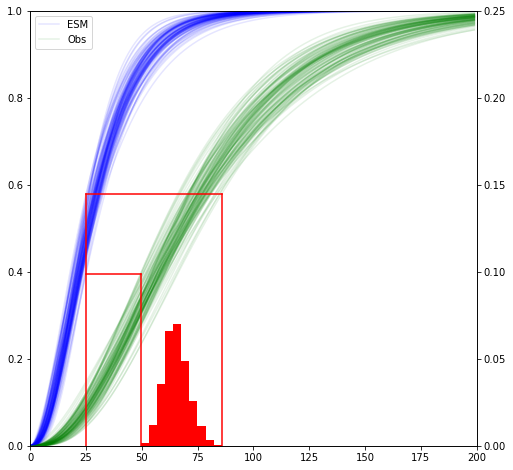

In [79]:
plt.figure(figsize= (8,8))
X= np.arange(200)
for cdf_esm,cdf_obs in zip(cdfs_esm,cdfs_obs):
    plt.plot(X,cdf_esm,'b',alpha= 0.1)
    plt.plot(X,cdf_obs,'g',alpha= 0.1)

plt.legend(['ESM','Obs'])
cdfs_obs=np.array(cdfs_obs)
cdfs_esm=np.array(cdfs_esm)

p_obs_95= np.max(cdfs_esm[:,point_example])
p_obs_05= np.min(cdfs_esm[:,point_example])

tr_color = 'r'
plt.plot([point_example,point_example],[0,p_obs_95],color=tr_color)

plt.plot([point_example,max(corrs)],[p_obs_95,p_obs_95],color=tr_color)
plt.plot([point_example,min(corrs)],[p_obs_05,p_obs_05],color=tr_color)

plt.plot([min(corrs),min(corrs)],[0,p_obs_05],color=tr_color)
plt.plot([max(corrs),max(corrs)],[0,p_obs_95],color=tr_color)


plt.ylim([0,1])
plt.xlim([0,200])

plt.gca().twinx()
plt.ylim([0,0.25])
plt.hist(np.array(corrs),density=True,color='r')


In [ ]:
def bias_corr_historical_gamma_zeros_uncen(data_grid_obs,data_grid_hist,to_corr):
    var_data_obs = data_grid_obs
    var_data_hist = data_grid_hist

    var_data_obs[var_data_obs<0]=0
    var_data_hist[var_data_hist<0]=0

    var_data_obs[np.isnan(var_data_obs)]=0
    var_data_hist[np.isnan(var_data_hist)]=0

    bias_corr=np.zeros(var_data_hist.shape[0]);

    data=var_data_hist
    data_non_zeros=(data[data!=0])
    count_zeros=(data[data==0].shape[0])
    count_total=(data.shape[0])
    p_zeros=count_zeros/count_total
    fita,fitloc,fitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)
    cdf= p_zeros + (1 - p_zeros) * scipy.stats.gamma.cdf(var_data_hist, a=fita,loc=fitloc,scale=fitscale)
    
    X= np.arange(200)
    cdf_esm= p_zeros + (1 - p_zeros) * scipy.stats.gamma.cdf(X, a=fita,loc=fitloc,scale=fitscale)

    
    
    data=var_data_obs
    data_non_zeros=(data[data!=0])
    count_zeros=(data[data==0].shape[0])
    count_total=(data.shape[0])
    p_zeros_imd=count_zeros/count_total
    ofita,ofitloc,ofitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)

    
    cdfi= p_zeros + (1 - p_zeros) * scipy.stats.gamma.cdf(to_corr, a=fita,loc=fitloc,scale=fitscale)
    
    X= np.arange(200)
    cdf_obs= p_zeros + (1 - p_zeros) * scipy.stats.gamma.cdf(X, a=ofita,loc=ofitloc,scale=ofitscale)

    z=(cdfi-p_zeros_imd)/(1-p_zeros_imd)
    bias_corr=scipy.stats.gamma.ppf(z, a=ofita,loc=ofitloc,scale=ofitscale)
    
    

    return bias_corr,cdf_obs,cdf_esm

In [24]:
import scipy
from scipy.stats import gamma


def bias_corr_historical_gamma_zeros(data_grid_obs,data_grid_hist):
  var_data_obs = data_grid_obs
  var_data_hist = data_grid_hist

  var_data_obs[var_data_obs<0]=0
  var_data_hist[var_data_hist<0]=0
  
  var_data_obs[np.isnan(var_data_obs)]=0
  var_data_hist[np.isnan(var_data_hist)]=0

  bias_corr=np.zeros(var_data_hist.shape[0]);

  data=var_data_hist
  data_non_zeros=(data[data!=0])
  count_zeros=(data[data==0].shape[0])
  count_total=(data.shape[0])
  p_zeros=count_zeros/count_total
  fita,fitloc,fitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)

  cdf= p_zeros + (1 - p_zeros) * scipy.stats.gamma.cdf(var_data_hist, a=fita,loc=fitloc,scale=fitscale)

  data=var_data_obs
  data_non_zeros=(data[data!=0])
  count_zeros=(data[data==0].shape[0])
  count_total=(data.shape[0])
  p_zeros_imd=count_zeros/count_total
  ofita,ofitloc,ofitscale = scipy.stats.gamma.fit(data_non_zeros,floc=0)

  for iter in range(cdf.shape[0]):
    cdfi=cdf[iter]
    if cdfi<=p_zeros_imd:
      bias_corr[iter]=0
    else:
      z=(cdfi-p_zeros_imd)/(1-p_zeros_imd)
      bias_corr[iter]=scipy.stats.gamma.ppf(z, a=ofita,loc=ofitloc,scale=ofitscale)

  return bias_corr

In [31]:
from tqdm import tqdm

data_bc = []

for it1,samp in tqdm(enumerate(samples)):
    for it2,samp_obs in enumerate(samples_obs):
        a = bias_corr_historical_gamma_zeros(samp_obs,samp)
        data_bc.append(a)

100it [01:07,  1.48it/s]


In [32]:
samp.shape

(105,)

68.42950985742775

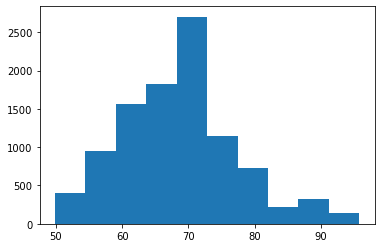

In [33]:
data_np=np.array(data_bc)
plt.hist(data_np[:,104])

np.mean(data_np[:,:50])

In [34]:
print(data_np[-1,50])

87.08147648740751


In [35]:
mean_first_half = np.mean(data_np[:,:50])
mean_second_half = np.mean(data_np[:,55:105])

sigma_first_half = 1/50*np.sqrt(np.sum(np.std(data_np[:,:50],axis=0)**2))
sigma_second_half = 1/50*np.sqrt(np.sum(np.std(data_np[:,55:105],axis=0)**2))



In [36]:
sigma_second_half


1.1396324345715432

In [37]:
sigma_first_half

1.1259899816058596

In [38]:
(mean_second_half-mean_first_half)

-0.1450055672780195

In [39]:
(mean_second_half-mean_first_half)/(sigma_second_half+sigma_first_half)

-0.06400253027275189

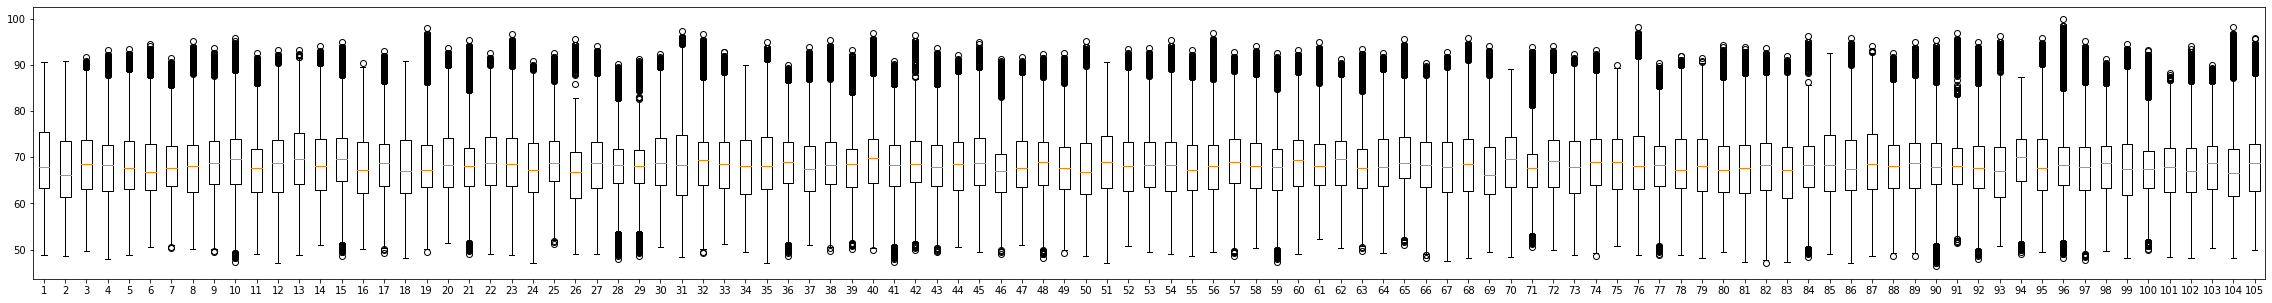

In [40]:
plt.figure(figsize= (40,5))
plt.boxplot(data_np)
plt.show()

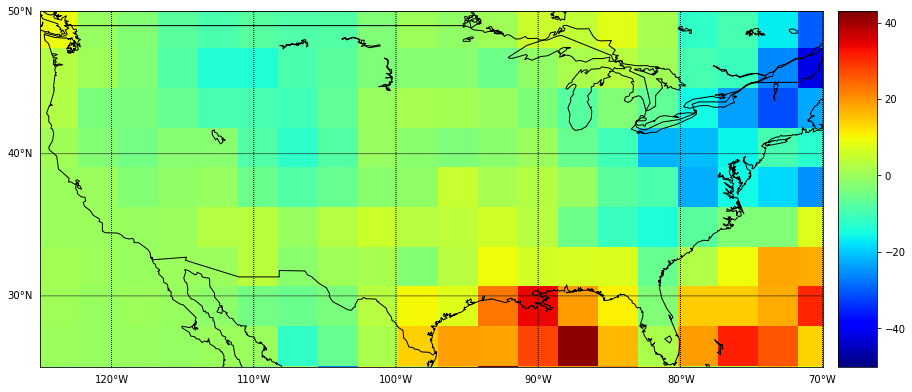

In [41]:
data_July  =  pre_gcm[:,:,:].reshape((12,-1,pre_gcm.shape[1],pre_gcm.shape[2]),order = 'F' )[6,:]
delta = np.mean(data_July[55:105,:,:],axis=0) - np.mean(data_July[:50,:,:] ,axis=0)



uu.map_plot_cyl(delta,lat_gcm,lon_gcm,map_bounds,mp_spacing=10)


# grids

In [43]:
N=105
B=10
N1= pre_gcm.shape[1]
N2= pre_gcm.shape[2]
bias_corrected_uncen_output = np.zeros((N1,N2,B*B,N))

from tqdm import tqdm

data_bc = []
for n1 in tqdm(range(N1)):
    for n2 in range(N2):
        data_July  =  pre_gcm[:,n1,n2].reshape((12,-1),order = 'F' )[6,:]
        data_July_obs  =  pre_obs_coarse[:,n1,n2].reshape((12,-1),order = 'F' )[6,:] 
        
        x=data_July
        N=x.shape[0]
        samples= []
        for i in range(B):
            y = np.random.choice(x.tolist(), N, replace=True)
            samples.append(y)


        x=data_July_obs
        N=x.shape[0]
        samples_obs= []
        for i in range(B):
            y = np.random.choice(x.tolist(), N, replace=True)
            samples_obs.append(y)
        data_bc=[]
        for samp in samples:
            for samp_obs in samples_obs:
                a = bias_corr_historical_gamma_zeros(samp_obs,samp)
                data_bc.append(a)
                
        bias_corrected_uncen_output[n1,n2,:,:]=np.array(data_bc)
        

100%|███████████████████████████████████████████| 11/11 [02:41<00:00, 14.72s/it]


In [44]:
bias_corrected_uncen_output

array([[[[ 77.13194813,  67.49803561,  69.90034323, ...,  79.02113697,
           69.60303731,  74.15512416],
         [ 79.08450029,  65.497354  ,  68.83800684, ...,  81.80501329,
           68.4227794 ,  74.83350958],
         [ 77.07916756,  66.0135852 ,  68.75776851, ...,  79.2669489 ,
           68.41757942,  73.64320103],
         ...,
         [ 68.47840778,  68.64928958,  67.40236686, ...,  66.52889245,
           62.00531137,  71.500745  ],
         [ 69.24545685,  69.43156208,  68.07410877, ...,  67.12398368,
           62.21419544,  72.54050634],
         [ 68.4564746 ,  68.65359261,  67.21639841, ...,  66.21128111,
           61.02868314,  71.95016971]],

        [[ 67.96031304,  66.85815762, 119.74662802, ...,  75.23263446,
           69.90078194,  76.63077194],
         [ 67.15996468,  66.02662876, 120.83425437, ...,  74.65013986,
           69.15654934,  76.0924145 ],
         [ 67.36161215,  66.21464991, 121.78029995, ...,  74.9446768 ,
           69.38248713,  76.40536

In [45]:
(N1,N2,B*B,N)

(11, 22, 100, 105)

In [46]:
bias_corrected_uncen_output.shape

(11, 22, 100, 105)

In [47]:
p_obs  =  pre_obs_coarse[:,:,:].reshape((12,-1,N1,N2),order = 'F' )[6,:]
p_gcm  =  pre_gcm[:,:,:].reshape((12,-1,N1,N2),order = 'F' )[6,:]

_bias =  p_gcm  -  p_obs
_std = np.moveaxis(np.std(bias_corrected_uncen_output,axis=2),2,0)



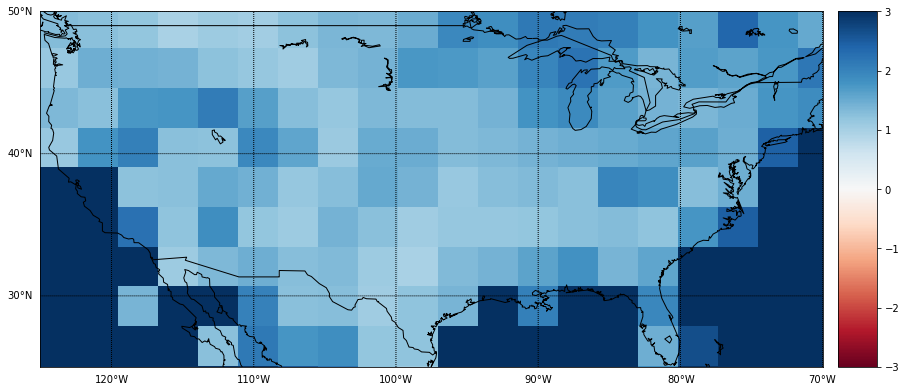

NameError: name '_d' is not defined

In [50]:
# data_plot = np.mean(np.abs(_std),axis=0)
# map_plot_cyl(data_plot,lat_gcm,lon_gcm,map_bounds,mp_spacing=10,vv=100)


# data_plot = np.mean(np.abs(_bias),axis=0)
# map_plot_cyl(data_plot,lat_gcm,lon_gcm,map_bounds,mp_spacing=10,vv=200)


# data_plot = np.mean(np.abs(_std/_bias*100),axis=0)
# map_plot_cyl(data_plot,lat_gcm,lon_gcm,map_bounds,mp_spacing=10,vv=500)


data_plot = (np.mean(np.abs(_bias/_std),axis=0))
map_plot_cyl(data_plot,lat_gcm,lon_gcm,map_bounds,mp_spacing=10,vv=3)


data_plot = (np.mean(np.abs(_std/_d),axis=0))
map_plot_cyl(data_plot,lat_gcm,lon_gcm,map_bounds,mp_spacing=10,vv=3)


In [ ]:
mean_first_half = np.mean(bias_corrected_uncen_output[:,:,:,:50],axis=(2,3))
mean_second_half = np.mean(bias_corrected_uncen_output[:,:,:,55:105],axis=(2,3))

sigma_first_half = 1/B*np.sqrt(np.sum(np.std(bias_corrected_uncen_output[:,:,:,:50],axis=2)**2,axis=2))
sigma_second_half = 1/B*np.sqrt(np.sum(np.std(bias_corrected_uncen_output[:,:,:,55:105],axis=2)**2,axis=2))



(11, 22)


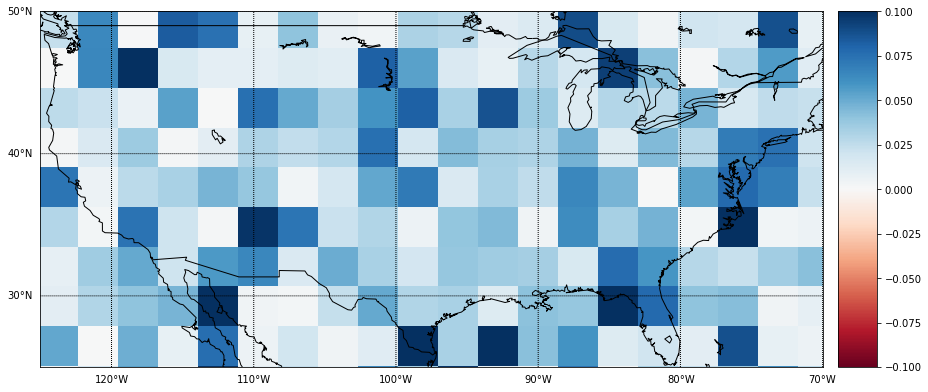

In [48]:
print(delta.shape)

delta=np.abs(mean_second_half-mean_first_half)/(sigma_second_half+sigma_first_half)
map_plot_cyl(delta,lat_gcm,lon_gcm,map_bounds,mp_spacing=10,vv=0.10)


In [49]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

def map_plot_cyl(data_lat_x_lon,lat_cen,lon_cen,map_bounds,mp_spacing=10,vv=10):
  

  lat_box=uu.cen_to_box(lat_cen)
  lon_box=uu.cen_to_box(lon_cen)

  fig=plt.figure(figsize=(15,7))
  map = Basemap(projection='cyl',resolution='l',
                llcrnrlon=map_bounds[0], 
                urcrnrlat=map_bounds[1],
                urcrnrlon=map_bounds[2], 
                llcrnrlat=map_bounds[3])


  xx, yy = np.meshgrid(lon_box,lat_box )
  #return  dimenion of lat * lon

  map.pcolor(xx, yy, data_lat_x_lon,cmap='RdBu',vmax=vv,vmin=-vv)
  map.drawmeridians(np.arange(-180,180,mp_spacing),labels=[0,0,0,1], linewidth=1.0) #longitudes
  map.drawparallels(np.arange(-90,90,mp_spacing),labels=[1,0,0,0], linewidth=1.0) #latitudes

  map.drawcountries(linewidth=1)
  map.drawcoastlines(linewidth=1)

  map.colorbar()

  plt.show()

(1.0085247592227882, 0.00040335727972593216, 1.503906356110496)

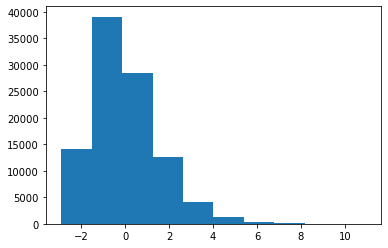

In [80]:
import scipy.stats
data = scipy.stats.pearson3.rvs(size=100000, loc=0, scale=1.5,skew = 1)
plt.hist(data)

a,b,c = scipy.stats.pearson3.fit(data)
a,b,c